In [1]:
import pandas as pd
import numpy as np
import time
import spacy
import random
from pathlib import Path
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchtext import data 
import torchtext
import en_core_web_sm
from nltk.tokenize.treebank import TreebankWordDetokenizer
import matplotlib.pyplot as plt
%matplotlib inline

<a id='section1'></a>
# 1. Obtener los datos

El conjunto de datos a utilizar será sentiment140.

In [2]:
ENCODING = "ISO-8859-1"
COLUMNS = ["target", "id", "date", "flag", "user", "text"]

twitter_data = pd.read_csv('dataset.csv',  encoding =ENCODING , names=COLUMNS)
twitter_data.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


<a id='section2'></a>
# 2. Explorar los datos para obtener información

Contiene 1,600,000 tweets extraídos usando la API de Twitter. Los tweets se han anotado (0 = negativo, 2 = neutral, 4 = positivo) y se pueden utilizar para detectar sentimientos. El idioma en el que están es el inglés.

In [3]:
print("Tamaño del conjunto de datos:", len(twitter_data))

Tamaño del conjunto de datos: 1600000


El conjunto de datos contiene los siguientes 6 campos:
- target: la polaridad del tweet (0 = negativo, 2 = neutral, 4 = positivo)
- ids: la identificación del tweet 
- date: la fecha del tweet
- flag: la consulta. Si no hay ninguna consulta, este valor es NO_QUERY.
- user: el usuario que tuiteó 
- text: el texto del tweet

In [4]:
print("Información sobre el conjunto de datos \n")
print(twitter_data.info())

Información sobre el conjunto de datos 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB
None


<p style="font-family: Arial; font-size:1.4em;color:blue;"> Sentimientos </p>

Los sentimientos dentro del conjunto de datos se distribuye entre los valores de sentimiento positivo y negativo. En un gráfico de barras se desplegará la cantidad de tweets negativos en rojo y tweets positivos en verde.

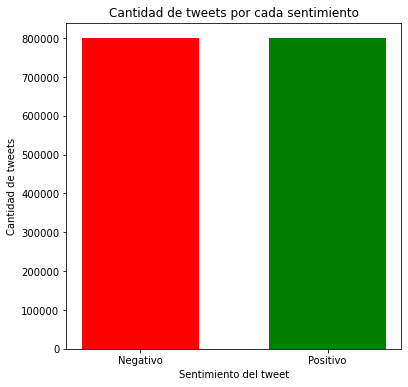

In [5]:
class_count = twitter_data['target'].value_counts()
plt.figure(figsize = (6, 6))
plt.xticks([4, 0], ['Positivo', 'Negativo'])
plt.xticks([4, 0])
plt.bar(x = class_count.keys(), 
        height = class_count.values, 
        color = ['g', 'r'], width = 2.5)
plt.xlabel("Sentimiento del tweet")
plt.ylabel("Cantidad de tweets")
plt.title("Cantidad de tweets por cada sentimiento")
plt.show()

Ya que dentro del conjunto de datos sólo encontramos sentimientos positivos o negativos, se hará un reemplazo de la etiqueta target con el valor 4 al valor 1, donde 0 es negativo y 1 es positivo.

In [6]:
twitter_data['target']=twitter_data['target'].replace(to_replace=4,value=1)

Al tener un conjunto de datos tan grande, se optó por tomar un subconjunto más pequeño para el entrenamiento, este contará con un tamaño de 100000 tweets.

In [94]:
twitter_data.sample(100000).to_csv("small_dataset.csv", header=None, index=None)

In [59]:
dataset = pd.read_csv('small_dataset.csv',  encoding =ENCODING , names=COLUMNS)
dataset.head()

,target,id,date,flag,user,text
0,1,1981456280,Sun May 31 09:11:30 PDT 2009,NO_QUERY,mealooove,says @^&amp;$%*@!#$ andaming errors sa post ko...
1,1,2187344639,Mon Jun 15 20:08:43 PDT 2009,NO_QUERY,DanielleluvsGod,yay! the bachelorette is on now!
2,1,1970521453,Sat May 30 04:12:02 PDT 2009,NO_QUERY,ahunsal,Kahkahaya haz?r olun. --&gt; Stavros Flatly -...
3,1,2067454342,Sun Jun 07 12:22:20 PDT 2009,NO_QUERY,natflores,Had so much Fun with the Abu Dhabi Group...
4,0,1964685230,Fri May 29 14:38:08 PDT 2009,NO_QUERY,ardowdle,"@dennispillion @WaffleSauce Ugh, you people an..."


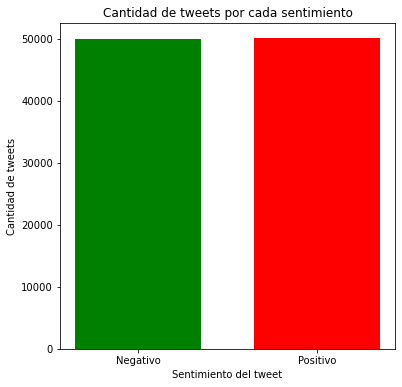

In [60]:
class_count = dataset['target'].value_counts()
plt.figure(figsize = (6, 6))
plt.xticks([1, 0], ['Positivo', 'Negativo'])
plt.xticks([1, 0])
plt.bar(x = class_count.keys(), 
        height = class_count.values, 
        color = ['r', 'g'], width = 0.7)
plt.xlabel("Sentimiento del tweet")
plt.ylabel("Cantidad de tweets")
plt.title("Cantidad de tweets por cada sentimiento")
plt.show()

<a id='section3'></a>
# 3. Preparación de los datos

In [95]:
TEXT = data.Field(tokenize='spacy',  tokenizer_language='en_core_web_sm',lower=True, include_lengths= True)
LABEL = data.LabelField(dtype=torch.float)

cols = [('target', LABEL), ('id',None),('date',None),('flag',None),('user',None), ('text', TEXT)]

dataset = torchtext.data.TabularDataset(
        path="small_dataset.csv",
        format="CSV",
        fields=cols,
        skip_header=False)

Dividir los datos en los conjuntos de entrenamiento(70%), prueba(20%) y validación (10%).

In [96]:
(train, test, valid) = dataset.split(split_ratio=[0.7,0.1,0.2])

print("Tamaño del conjunto de entrenamiento: {}".format(len(train)))
print("Tamaño del conjunto de validación: {}".format(len(valid)))
print("Tamaño del conjunto de prueba: {}".format(len(test)))

Tamaño del conjunto de entrenamiento: 70000
Tamaño del conjunto de validación: 10000
Tamaño del conjunto de prueba: 20000


In [63]:
print(vars(train.examples[2]))

{'target': '1', 'text': ['had', 'a', 'good', 'night', 'at', 'open', 'mic', 'at', 'the', 'yucca', 'tap', 'room', '.']}


### **Build Vocabulary**
Build the vocabulary for the training set using pre-trained GloVe embeddings.
GloVe embeddings were trained on 6 billion tokens and the embeddings are 100-dimensional.

In [97]:
MAX_VOCAB_SIZE = 25000

# unk_init initializes words in the vocab using the Gaussian distribution
TEXT.build_vocab(train, 
                 max_size = MAX_VOCAB_SIZE,
                 vectors = "glove.6B.100d",
                 unk_init = torch.Tensor.normal_)

In [98]:
# build vocab for training set - convert words into integers
LABEL.build_vocab(train)

In [99]:
# Most frequent tokens
TEXT.vocab.freqs.most_common(10)

[('i', 43731),
 ('!', 39589),
 ('.', 35379),
 (' ', 25605),
 ('to', 24890),
 ('the', 23134),
 (',', 21035),
 ('a', 16378),
 ('my', 13799),
 ('it', 13391)]

### **Iterator**
Pad each tweet to be the same length to process in batch. 
The BucketIterator will group tweets of similar lengths together for minimized padding in each batch.


In [100]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

Using device: cpu



In [101]:
BATCH_SIZE = 128
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train, valid, test),
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text),
    sort_within_batch = True)

<a id='section4'></a>
# **4. Modelo**

In [69]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        self.encoder = nn.LSTM(embedding_dim, 
                               hidden_dim, 
                               num_layers=n_layers,
                               bidirectional=bidirectional,
                               dropout=dropout)
        self.predictor = nn.Linear(hidden_dim*2, output_dim)
        self.dropout = nn.Dropout(dropout)
      
    def forward(self, text, text_lengths):
        embedded = self.dropout(self.embedding(text))    
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        packed_output, (hidden, cell) = self.encoder(packed_embedded)
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        return self.predictor(hidden)

### **Creación del Modelo**

In [102]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model_LSTM = LSTM(INPUT_DIM,
            EMBEDDING_DIM,
            HIDDEN_DIM,
            OUTPUT_DIM,
            N_LAYERS,
            False,
            DROPOUT,
            PAD_IDX)

model_BiLSTM = LSTM(INPUT_DIM,
            EMBEDDING_DIM,
            HIDDEN_DIM,
            OUTPUT_DIM,
            N_LAYERS,
            True,
            DROPOUT,
            PAD_IDX)

#Copy the pre-trained word embeddings into the embedding layer

In [103]:
pretrained_embeddings = TEXT.vocab.vectors

print("Tamaño del vocabulario: ", pretrained_embeddings.shape[0])
print("Dimensión del embedding: ",pretrained_embeddings.shape[1])

Tamaño del vocabulario:  25002
Dimensión del embedding:  100


#Replace the initial weights of the embedding layer with the pre-trained embeddings

In [72]:
model_LSTM.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 0.2681, -0.8466,  0.5953,  ...,  0.2383,  1.4950,  0.8300],
        [-1.1811,  0.3584, -1.0999,  ..., -0.1563,  0.1947, -1.1907],
        [-0.0465,  0.6197,  0.5665,  ..., -0.3762, -0.0325,  0.8062],
        ...,
        [ 1.0689, -1.5650,  0.1727,  ...,  1.2660,  0.1263,  1.0982],
        [ 0.6092,  1.5649, -0.1410,  ...,  0.3049,  0.1241, -2.2766],
        [-1.4339, -0.7381, -0.0157,  ..., -0.5093, -2.3181,  0.6670]])

In [104]:
model_BiLSTM.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 1.8366,  0.5447,  2.2488,  ...,  1.6172, -0.0787, -0.6226],
        [-1.4872,  0.8297,  0.4875,  ...,  0.3673,  0.8060,  1.0164],
        [-0.0465,  0.6197,  0.5665,  ..., -0.3762, -0.0325,  0.8062],
        ...,
        [-0.9095, -0.0151, -0.2626,  ...,  1.6059,  1.6248,  2.0685],
        [ 0.9254,  1.5394,  1.6576,  ..., -0.2449,  1.0148,  0.3398],
        [-0.3455,  1.0553, -1.8628,  ..., -0.4209, -0.5933, -0.0934]])

In [105]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

#Setting row in the embedding weights matrix to zero using the token index

In [75]:
model_LSTM.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model_LSTM.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model_LSTM.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0465,  0.6197,  0.5665,  ..., -0.3762, -0.0325,  0.8062],
        ...,
        [ 1.0689, -1.5650,  0.1727,  ...,  1.2660,  0.1263,  1.0982],
        [ 0.6092,  1.5649, -0.1410,  ...,  0.3049,  0.1241, -2.2766],
        [-1.4339, -0.7381, -0.0157,  ..., -0.5093, -2.3181,  0.6670]])


In [106]:
model_BiLSTM.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model_BiLSTM.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model_BiLSTM.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0465,  0.6197,  0.5665,  ..., -0.3762, -0.0325,  0.8062],
        ...,
        [-0.9095, -0.0151, -0.2626,  ...,  1.6059,  1.6248,  2.0685],
        [ 0.9254,  1.5394,  1.6576,  ..., -0.2449,  1.0148,  0.3398],
        [-0.3455,  1.0553, -1.8628,  ..., -0.4209, -0.5933, -0.0934]])


<a id='section4'></a>
# **4. Training**

In [107]:
optimizer = optim.Adam(model_LSTM.parameters(), lr=2e-2)
criterion = nn.BCEWithLogitsLoss()
model = model_LSTM.to(device)
criterion = criterion.to(device)

In [108]:
model2 = model_BiLSTM.to(device)

In [111]:
def batch_accuracy(predictions, label):
    preds = torch.round(torch.sigmoid(predictions))
    correct = (preds == label).float()
    accuracy = correct.sum() / len(correct)
    return accuracy

def timer(start_time, end_time):
    time = end_time - start_time
    mins = int(time / 60)
    secs = int(time - (mins * 60))

    return mins, secs

In [112]:
def train(model, iterator, optimizer, criterion):
    training_acc = 0.0
    training_loss = 0.0
    
    model.train()
    for batch in iterator:
        optimizer.zero_grad()
        text, text_lengths = batch.text
        predictions = model(text, text_lengths).squeeze(1)
        loss = criterion(predictions, batch.target)
        accuracy = batch_accuracy(predictions, batch.target)
        loss.backward()
        optimizer.step()
        training_acc += accuracy.item()
        training_loss += loss.item()
        

    return training_loss / len(iterator), training_acc / len(iterator)

In [113]:
def evaluate(model, iterator, criterion):
    eval_acc = 0.0
    eval_loss = 0.0
   
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            predictions = model(text, text_lengths).squeeze(1)
            loss = criterion(predictions, batch.target)
            accuracy = batch_accuracy(predictions, batch.target)
            eval_loss += loss.item()
            eval_acc += accuracy.item()

    return eval_loss / len(iterator), eval_acc / len(iterator)

### **Train the model**

In [82]:
history_train_loss = []
history_train_acc = []
history_valid_loss = []
history_valid_acc = []
history_epochs = []

In [83]:
EPOCHS = 5
best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    start_time = time.time()
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    history_train_loss.append(train_loss) 
    history_train_acc.append(train_acc)
    history_valid_loss.append(valid_loss)
    history_valid_acc.append(valid_acc)
    history_epochs.append(epoch)
    
    end_time = time.time()
    mins, secs = timer(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model-sd.pt')

    print("Época {}:".format(epoch+1))
    print("\t Tiempo Total : {}m {}s".format(mins, secs))
    print("\t Pérdida en entrenamiento : {} | Accuracy en entrenamiento: {}%".format(round(train_loss, 2), round(train_acc*100, 2)))
    print("\t Pérdida en validación : {} | Accuracy en validación: {}%".format(round(valid_loss, 2), round(valid_acc*100, 2)))

Época 1:
	 Tiempo Total : 2m 52s
	 Pérdida en entrenamiento : 0.54 | Accuracy en entrenamiento: 72.97%
	 Pérdida en validación : 0.46 | Accuracy en validación: 78.64%
Época 2:
	 Tiempo Total : 2m 56s
	 Pérdida en entrenamiento : 0.47 | Accuracy en entrenamiento: 78.61%
	 Pérdida en validación : 0.49 | Accuracy en validación: 77.45%
Época 3:
	 Tiempo Total : 4m 18s
	 Pérdida en entrenamiento : 0.61 | Accuracy en entrenamiento: 68.35%
	 Pérdida en validación : 0.63 | Accuracy en validación: 64.73%
Época 4:
	 Tiempo Total : 5m 22s
	 Pérdida en entrenamiento : 0.72 | Accuracy en entrenamiento: 58.49%
	 Pérdida en validación : 0.65 | Accuracy en validación: 61.68%
Época 5:
	 Tiempo Total : 5m 31s
	 Pérdida en entrenamiento : 0.73 | Accuracy en entrenamiento: 56.8%
	 Pérdida en validación : 0.69 | Accuracy en validación: 56.96%


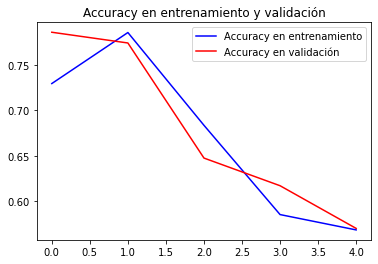

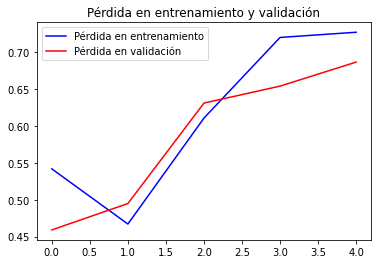

In [84]:
plt.plot(history_epochs,history_train_acc, 'b', label='Accuracy en entrenamiento')
plt.plot(history_epochs,history_valid_acc, 'r', label='Accuracy en validación')
plt.title('Accuracy en entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(history_epochs, history_train_loss, 'b', label='Pérdida en entrenamiento')
plt.plot(history_epochs, history_valid_loss, 'r', label='Pérdida en validación')
plt.title('Pérdida en entrenamiento y validación')
plt.legend()

plt.show()

In [114]:
history_train_loss2 = []
history_train_acc2 = []
history_valid_loss2 = []
history_valid_acc2 = []
history_epochs2 = []

In [115]:
EPOCHS = 5
best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    start_time = time.time()
    train_loss, train_acc = train(model2, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model2, valid_iterator, criterion)
    
    history_train_loss2.append(train_loss) 
    history_train_acc2.append(train_acc)
    history_valid_loss2.append(valid_loss)
    history_valid_acc2.append(valid_acc)
    history_epochs2.append(epoch)
    
    end_time = time.time()
    mins, secs = timer(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model2.state_dict(), 'model2-sd.pt')

    print("Época {}:".format(epoch+1))
    print("\t Tiempo Total : {}m {}s".format(mins, secs))
    print("\t Pérdida en entrenamiento : {} | Accuracy en entrenamiento: {}%".format(round(train_loss, 2), round(train_acc*100, 2)))
    print("\t Pérdida en validación : {} | Accuracy en validación: {}%".format(round(valid_loss, 2), round(valid_acc*100, 2)))

Época 1:
	 Tiempo Total : 5m 35s
	 Pérdida en entrenamiento : 0.69 | Accuracy en entrenamiento: 51.73%
	 Pérdida en validación : 0.69 | Accuracy en validación: 50.1%
Época 2:
	 Tiempo Total : 5m 41s
	 Pérdida en entrenamiento : 0.69 | Accuracy en entrenamiento: 51.68%
	 Pérdida en validación : 0.69 | Accuracy en validación: 50.1%
Época 3:
	 Tiempo Total : 5m 39s
	 Pérdida en entrenamiento : 0.69 | Accuracy en entrenamiento: 51.77%
	 Pérdida en validación : 0.69 | Accuracy en validación: 50.1%
Época 4:
	 Tiempo Total : 5m 33s
	 Pérdida en entrenamiento : 0.69 | Accuracy en entrenamiento: 51.69%
	 Pérdida en validación : 0.69 | Accuracy en validación: 50.1%
Época 5:
	 Tiempo Total : 5m 21s
	 Pérdida en entrenamiento : 0.69 | Accuracy en entrenamiento: 51.84%
	 Pérdida en validación : 0.69 | Accuracy en validación: 50.1%


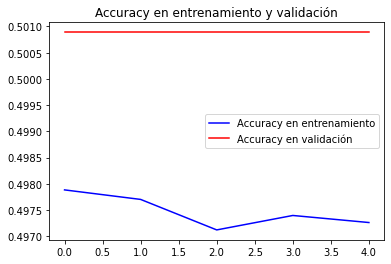

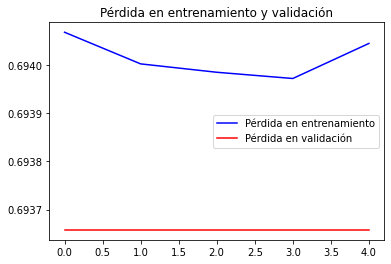

In [93]:
plt.plot(history_epochs2,history_train_acc2, 'b', label='Accuracy en entrenamiento')
plt.plot(history_epochs2,history_valid_acc2, 'r', label='Accuracy en validación')
plt.title('Accuracy en entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(history_epochs2, history_train_loss2, 'b', label='Pérdida en entrenamiento')
plt.plot(history_epochs2, history_valid_loss2, 'r', label='Pérdida en validación')
plt.title('Pérdida en entrenamiento y validación')
plt.legend()

plt.show()

<a id='section5'></a>
# **5. Predicción**

In [90]:
model.load_state_dict(torch.load('model-sd.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion)

print("Pérdida en prueba: {} | Accuracy en prueba: {}%".format(round(test_loss, 2), round(test_acc*100, 2)))

Pérdida en prueba: 0.45 | Accuracy en prueba: 79.02%


In [116]:
nlp = spacy.load('en_core_web_sm')

def predict(model, text, tokenized=True):
    model.eval()

    if tokenized == False:
        tokens = [token.text for token in nlp.tokenizer(text)]
    else:
        tokens = text

    indexed_tokens = [TEXT.vocab.stoi[t] for t in tokens]
    length = [len(indexed_tokens)]
    tensor = torch.LongTensor(indexed_tokens).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    prediction = torch.sigmoid(model(tensor, length_tensor))
    return prediction.item()

In [118]:
print("Tweet: {}".format(TreebankWordDetokenizer().detokenize(test[10].text)))
print("Predicción: {}".format(round(predict(model, test[10].text), 2)))
print("Etiqueta verdadera: {}".format(test[10].target))

Tweet: listening to music
Predicción: 0.52
Etiqueta verdadera: 1


In [119]:
d = []

for idx in range(10):
    tweet = TreebankWordDetokenizer().detokenize(test[idx].text)
    d.append({'Tweet': tweet, 'Predicción': predict(model, test[idx].text), 'Etiqueta verdadera': test[idx].target})

pd.DataFrame(d)

AttributeError: 'Example' object has no attribute 'label'